# RNN을 활용한 BaselineModel

In [1]:
# GPU로 Tesla T4가 준비돼있습니다.
!nvidia-smi

Wed Jun 26 06:00:19 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.239.06   Driver Version: 470.239.06   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import json

## 1. 데이터 가져오기

In [3]:
train_data_path ="~/aiffel/dktc/data/train.csv"
data = pd.read_csv(train_data_path)
data.head()

,idx,class,conversation
0,0,협박 대화,지금 너 스스로를 죽여달라고 애원하는 것인가?\n 아닙니다. 죄송합니다.\n 죽을 ...
1,1,협박 대화,길동경찰서입니다.\n9시 40분 마트에 폭발물을 설치할거다.\n네?\n똑바로 들어 ...
2,2,기타 괴롭힘 대화,너 되게 귀여운거 알지? 나보다 작은 남자는 첨봤어.\n그만해. 니들 놀리는거 재미...
3,3,갈취 대화,어이 거기\n예??\n너 말이야 너. 이리 오라고\n무슨 일.\n너 옷 좋아보인다?...
4,4,갈취 대화,저기요 혹시 날이 너무 뜨겁잖아요? 저희 회사에서 이 선크림 파는데 한 번 손등에 ...


In [4]:
data.shape

(3950, 3)

## 2. 데이터 전처리

### 2-1)결측치, 중복데이터 확인

In [5]:
print(data.isna().sum())

idx             0
class           0
conversation    0
dtype: int64


In [6]:
#중복인 행 확인
data['duplicates'] = data.duplicated(['conversation'])
data[data['duplicates'] == True]

,idx,class,conversation,duplicates
392,392,기타 괴롭힘 대화,병신이 아이스크림 먹게 돼 있냐?\n난 먹으면 안 돼? 그만 좀 해.\n당연히 안 ...,True
523,523,직장 내 괴롭힘 대화,과장님. 저 이번에 휴가 좀 갔다와도 되겠습니까.?\n휴가? 왜??\n좀 쉬다가 오...,True
789,789,기타 괴롭힘 대화,야 얘 이 쪽 손가락 세 개밖에 없다\n엥 손가락이 세개밖에 없을 수가 있어?\n봐...,True
824,824,기타 괴롭힘 대화,이야 내동생 여자친구한테 편지쓰네?\n 아 형 돌려줘.\n 어디보자. 사랑하는 여친...,True
869,869,직장 내 괴롭힘 대화,지현씨 나 소개팅 좀 시켜줘봐\n네? 저 주변에 아는 사람이 없어서요\n아 상사라 ...,True
...,...,...,...,...
3797,3797,기타 괴롭힘 대화,너 이번 방학 때 쌍꺼풀 수술 하고왔지?\n아닌데?\n아니긴 뭐가 아니야. 눈이 이...,True
3798,3798,기타 괴롭힘 대화,안녕하세요 지금 먹방 촬영중인데 촬영가능할까요?\n안돼요\n한번만 안될까요?\n안돼...,True
3855,3855,기타 괴롭힘 대화,그 소문 진짜야? 너가 다른 애들 뒷담화하고 다녔다며?\n응? 나 그런 적 없는데?...,True
3874,3874,기타 괴롭힘 대화,야 니 왤캐 못생겼냐?\n뭐라그랬냐?\n으 나 보고 말하지마 니 얼굴보면 토나올거 ...,True


In [7]:
#중복제거
data = data.drop_duplicates(['conversation'])

In [8]:
#conversation과 class만 남김
data = data[['conversation','class']]
data.head()

,conversation,class
0,지금 너 스스로를 죽여달라고 애원하는 것인가?\n 아닙니다. 죄송합니다.\n 죽을 ...,협박 대화
1,길동경찰서입니다.\n9시 40분 마트에 폭발물을 설치할거다.\n네?\n똑바로 들어 ...,협박 대화
2,너 되게 귀여운거 알지? 나보다 작은 남자는 첨봤어.\n그만해. 니들 놀리는거 재미...,기타 괴롭힘 대화
3,어이 거기\n예??\n너 말이야 너. 이리 오라고\n무슨 일.\n너 옷 좋아보인다?...,갈취 대화
4,저기요 혹시 날이 너무 뜨겁잖아요? 저희 회사에서 이 선크림 파는데 한 번 손등에 ...,갈취 대화


In [9]:
data.shape

(3846, 2)

### 2-2)레이블인코딩

In [10]:
CLASS_NAMES = ['협박 대화', '갈취 대화', '직장 내 괴롭힘 대화', '기타 괴롭힘 대화']

encoder = LabelEncoder()
encoder.fit(CLASS_NAMES)

data['class'] = encoder.transform(data['class'])

corpus = data["conversation"]
data.head()

,conversation,class
0,지금 너 스스로를 죽여달라고 애원하는 것인가?\n 아닙니다. 죄송합니다.\n 죽을 ...,3
1,길동경찰서입니다.\n9시 40분 마트에 폭발물을 설치할거다.\n네?\n똑바로 들어 ...,3
2,너 되게 귀여운거 알지? 나보다 작은 남자는 첨봤어.\n그만해. 니들 놀리는거 재미...,1
3,어이 거기\n예??\n너 말이야 너. 이리 오라고\n무슨 일.\n너 옷 좋아보인다?...,0
4,저기요 혹시 날이 너무 뜨겁잖아요? 저희 회사에서 이 선크림 파는데 한 번 손등에 ...,0


### 2-3)토크나이저 및 단어사전 생성

In [11]:
def tokenize(corpus):
    #토크나이저 객체생성
    tokenizer = tf.keras.preprocessing.text.Tokenizer(
        num_words=1000, 
        filters=' ',
        oov_token="<unk>")
    
    tokenizer.fit_on_texts(corpus) #corpus 기준으로 단어 사전 생성
    tensor = tokenizer.texts_to_sequences(corpus) #정수시퀀스
    
    #시퀀스패딩
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, 
                                                           padding='post',
                                                           maxlen=20) #최대길이
    print(tensor,tokenizer)
    return tensor, tokenizer

#데이터셋에서 토큰화 및 패딩작업 결과를 저장
tensor, tokenizer = tokenize(corpus)

[[  1 210   1 ...   1  42   1]
 [  1   1   1 ...   1   1 401]
 [  1  97   1 ...   1 136   1]
 ...
 [495   3 110 ...  27   1   1]
 [  1   1 151 ... 348   1   1]
 [  1   1   1 ... 159 113   1]] <keras_preprocessing.text.Tokenizer object at 0x7963dc1ef1f0>


### 2-4)데이터 분할

In [12]:
X_train = tensor[:3300]
y_train = data['class'][:3300]
X_val = tensor[3300:3550]
y_val = data['class'][3300:3550]
X_test = tensor[3750:]
y_test = data['class'][3750:]

# 3. 모델생성 및 훈련

- baseline 모델은 바닐라 RNN 모델로 설정
- LSTM, GRU, 1D COV 등 모델 및 pretrained bert 등을 활용예정

## 3-1) 모델 구성

In [13]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding,SimpleRNN,Dropout, Dense


vocab_size = 1000  # 어휘 사전의 크기
word_vector_dim = 20  # 단어 하나를 표현하는 임베딩 벡터의 차원수

model = Sequential()
model.add(Embedding(vocab_size, word_vector_dim, input_length=None))
model.add(SimpleRNN(256)) 
model.add(Dropout(0.2)) 
model.add(Dense(128, activation='relu'))
model.add(Dense(4, activation='softmax'))  

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 20)          20000     
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 256)               70912     
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               32896     
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 516       
Total params: 124,324
Trainable params: 124,324
Non-trainable params: 0
_________________________________________________________________


In [14]:
from sklearn.metrics import f1_score, precision_score, recall_score

In [15]:
#모델 compile
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [16]:
#콜백함수
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor='val_loss',  # 검증 손실을 기준으로 조기 종료 여부 판단
    patience=10,         # 검증 손실이 개선되지 않는 epoch를 5회까지 허용
    restore_best_weights=True  # 가장 좋은 검증 손실을 낸 모델의 가중치 복원
)

## 3-2) 모델 학습

In [17]:
history = model.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val), callbacks=[early_stopping])

Epoch 1/100
104/104 [==============================] - 15s 22ms/step - loss: 1.3929 - accuracy: 0.2655 - val_loss: 1.3979 - val_accuracy: 0.2320
Epoch 2/100
104/104 [==============================] - 2s 19ms/step - loss: 1.3702 - accuracy: 0.3376 - val_loss: 1.3728 - val_accuracy: 0.3160
Epoch 3/100
104/104 [==============================] - 2s 20ms/step - loss: 1.2819 - accuracy: 0.4030 - val_loss: 1.3515 - val_accuracy: 0.3280
Epoch 4/100
104/104 [==============================] - 2s 19ms/step - loss: 1.2318 - accuracy: 0.4448 - val_loss: 1.3507 - val_accuracy: 0.3520
Epoch 5/100
104/104 [==============================] - 2s 20ms/step - loss: 1.0137 - accuracy: 0.5758 - val_loss: 1.6732 - val_accuracy: 0.3920
Epoch 6/100
104/104 [==============================] - 2s 20ms/step - loss: 0.8792 - accuracy: 0.6397 - val_loss: 1.3502 - val_accuracy: 0.4200
Epoch 7/100
104/104 [==============================] - 2s 20ms/step - loss: 0.7371 - accuracy: 0.7088 - val_loss: 1.4454 - val_accuracy

## 3-3) 학습과정 시각화

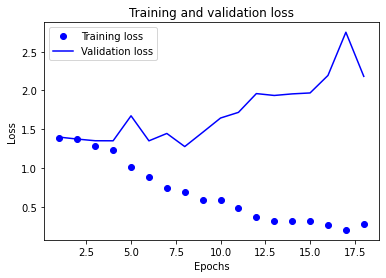

In [18]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

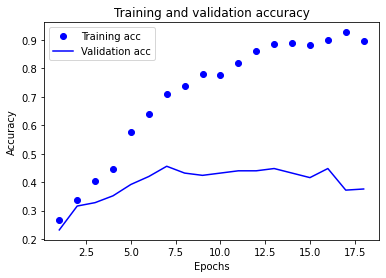

In [19]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## 3-4) 성능 확인

In [20]:
results = model.evaluate(X_test,y_test, verbose=2)

3/3 - 0s - loss: 1.3290 - accuracy: 0.4167


In [21]:
loss = results[0]
accuracy = results[1] 

In [22]:
# 예측
y_pred = model.predict(X_test)
y_pred_classes = y_pred.argmax(axis=-1)  # 예측 확률 값을 클래스 레이블로 변환

In [23]:
print(y_pred_classes)

[0 1 0 1 2 2 2 0 3 2 0 2 0 3 3 3 2 2 1 0 3 1 3 0 1 0 3 0 2 1 2 2 2 0 2 2 3
 2 1 0 1 1 0 3 0 0 1 3 2 0 2 0 2 3 3 0 0 0 0 1 3 0 3 3 1 0 1 2 0 0 3 1 0 1
 3 2 0 2 2 1 1 1 0 0 1 1 1 0 0 3 3 1 0 0 2 3]


In [24]:
from sklearn.metrics import classification_report

report_dict = classification_report(y_test, y_pred_classes)

print(report_dict)


              precision    recall  f1-score   support

           0       0.59      0.56      0.58        34
           1       0.32      0.27      0.29        26
           2       0.55      0.60      0.57        20
           3       0.10      0.12      0.11        16

    accuracy                           0.42        96
   macro avg       0.39      0.39      0.39        96
weighted avg       0.43      0.42      0.42        96



In [25]:
print(report_dict)

              precision    recall  f1-score   support

           0       0.59      0.56      0.58        34
           1       0.32      0.27      0.29        26
           2       0.55      0.60      0.57        20
           3       0.10      0.12      0.11        16

    accuracy                           0.42        96
   macro avg       0.39      0.39      0.39        96
weighted avg       0.43      0.42      0.42        96



In [26]:
report_dict = classification_report(y_test, y_pred_classes, output_dict=True)

# 필요한 값 추출 및 출력
precision = report_dict['weighted avg']['precision']
recall = report_dict['weighted avg']['recall']
f1 = report_dict['weighted avg']['f1-score']

print("weighted avg precision :", precision)
print("weighted avg recall :", recall)
print("weighted avg f1-score :", f1)

weighted avg precision : 0.42676373106060606
weighted avg recall : 0.4166666666666667
weighted avg f1-score : 0.42047333453583446


In [27]:
df = pd.DataFrame(report_dict)

In [28]:
df

,0,1,2,3,accuracy,macro avg,weighted avg
precision,0.593750,0.318182,0.545455,0.100000,0.416667,0.389347,0.426764
recall,0.558824,0.269231,0.600000,0.125000,0.416667,0.388264,0.416667
f1-score,0.575758,0.291667,0.571429,0.111111,0.416667,0.387491,0.420473
support,34.000000,26.000000,20.000000,16.000000,0.416667,96.000000,96.000000
